In [73]:
# baseline cnn model for fashion mnist
from numpy import mean
from numpy import std
import numpy as np
from matplotlib import pyplot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks

In [34]:
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

print("trainX shape:", trainX.shape, "y_train shape:", trainY.shape)

trainX shape: (60000, 28, 28, 1) y_train shape: (60000, 10)


In [35]:
# convert from integers to floats and normalize to range 0-1
trainX = trainX.astype('float32')/ 255.0
testX = testX.astype('float32')/ 255.0

In [42]:
input_6 = Input(shape=(28, 28, 1))

# left side
conv2d_5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))(input_6)
maxpooling2d_4 = MaxPooling2D(pool_size=(2, 2))(conv2d_5)
flatten_5 = Flatten()(maxpooling2d_4)

# right side
flatten_6 = Flatten()(input_6)
dense_6 = Dense(64, activation='relu')(flatten_6)

# merge 
concatenate_3 = Concatenate()([flatten_5, dense_6])
dense_7 = Dense(32, activation='relu', kernel_initializer='he_uniform')(concatenate_3)
dense_8 = Dense(10, activation='softmax')(dense_7)

# prediction output
model = Model(inputs=input_6, outputs=dense_8)
# summarize layers
print(model.summary())

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 26, 26, 32)   320         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 13, 13, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
flatten_30 (Flatten)            (None, 784)          0           input_16[0][0]                   
___________________________________________________________________________________________

In [43]:
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/Users/tzuchun/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [45]:
scores, histories = evaluate_model(trainX, trainY)

> 90.242
> 93.475
> 95.583
> 97.108
> 97.125


/Users/tzuchun/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/tzuchun/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


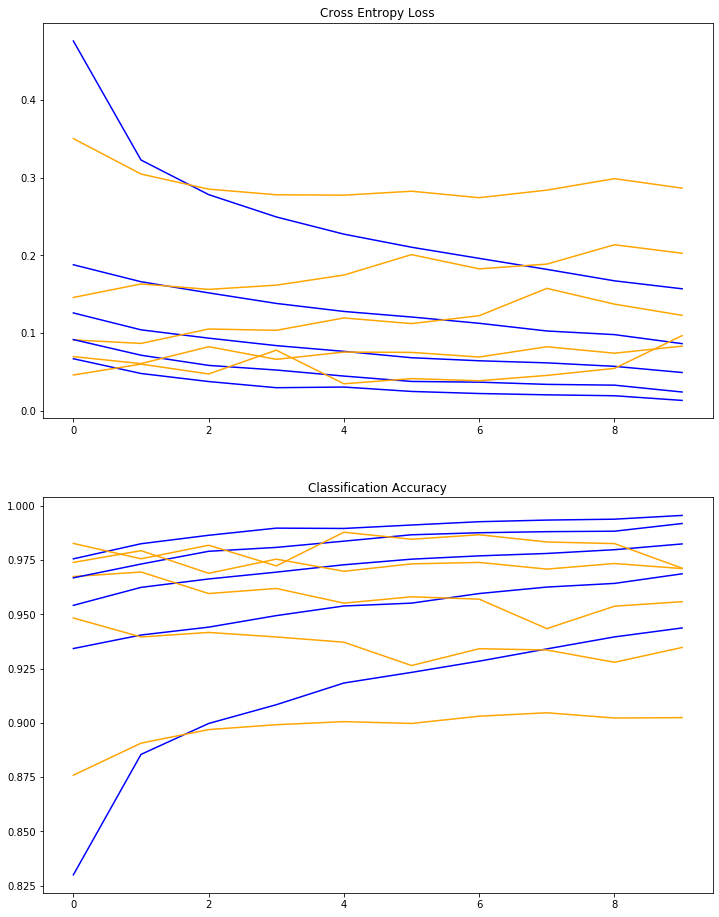

In [46]:
pyplot.figure(figsize=(12,16))
for i in range(len(histories)):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
pyplot.show()

Accuracy: mean=94.707 std=2.601, n=5


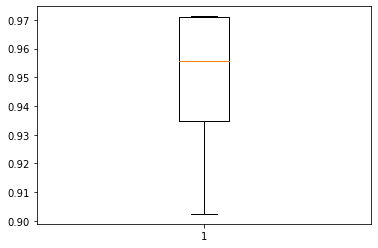

In [47]:
# print summary
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
pyplot.boxplot(scores)
pyplot.show()

In [74]:
# confusion_matrix
metrics.confusion_matrix(
    np.argmax(testY, axis=1), np.argmax(model.predict(testX), axis=1)
)  

array([[867,   0,  17,  27,   7,   1,  76,   0,   5,   0],
       [  1, 965,   1,  21,   7,   0,   4,   0,   1,   0],
       [ 20,   0, 882,  12,  63,   0,  21,   0,   2,   0],
       [ 25,   1,  14, 906,  33,   0,  19,   0,   2,   0],
       [  1,   1,  81,  29, 871,   0,  17,   0,   0,   0],
       [  2,   0,   0,   0,   0, 963,   0,  23,   0,  12],
       [128,   1, 118,  24, 131,   1, 584,   0,  13,   0],
       [  0,   0,   0,   0,   0,   7,   0, 976,   0,  17],
       [  3,   0,   2,   4,   4,   2,   3,   2, 979,   1],
       [  0,   0,   1,   0,   0,   3,   0,  38,   2, 956]])

In [84]:
micro = metrics.precision_score(
    np.argmax(testY, axis=1), np.argmax(model.predict(testX), axis=1), average='micro',
)
macro = metrics.precision_score(
    np.argmax(testY, axis=1), np.argmax(model.predict(testX), axis=1), average='macro',
)
weighted = metrics.precision_score(
    np.argmax(testY, axis=1), np.argmax(model.predict(testX), axis=1), average='weighted',
)
recall = metrics.recall_score(
    np.argmax(testY, axis=1), np.argmax(model.predict(testX), axis=1), average='weighted',
)
print('Precision: micro=%.3f macro=%.3f, weighted=%.3f' % (micro, macro, weighted))
print('Recall: %.3f'% (recall))

Precision: micro=0.895 macro=0.896, weighted=0.896
Recall: 0.895
